In [2]:
%load_ext autoreload
%autoreload 2

# Simulation settings

In [3]:
from utils.hexec import create_estimator_options
from utils.hexec import ExecDB

L = 16
J = 1
h = 0.05
lamb = 0.7
g_arr = [None, 8]

x_basis = False

particle_pair_left_position = L//2 - 1 
particle_pair_length = 1

final_time = 8
steps = 35

shots = 50000

odr = True

execution_database = "z2_chain_jobs_postselection.json"
jobs_result_folder = execution_database.split(".")[0] + "/"
job_db = ExecDB(execution_database)

circ_folder_path = "Circuits/"

# Load results

In [4]:
from z2chain.circs import physical_particle_pair_quench_simulation_circuits, erradj_particle_pair_quench_simulation_circuits, odr_compuncomp_circuits
from z2chain.operators import local_pauli_z, local_pauli_x, postselection_operators
from cobos.tokens import ibm_token, group_instance, group_instance2
from utils.postselection import load_postselected_jobs
from utils.hexec import get_backend_best_qubit_chain
from qiskit_ibm_runtime import QiskitRuntimeService
from utils.circs import generate_and_save_circs
from functools import partial
from itertools import product
import os
# from fradm.tokens import ibm_token, group_instance

if len(g_arr) != 2:
    raise ValueError("This is only intended for comparison between 2 g values")

channel = "ibm_quantum"
# device = "ibm_kyiv"
# device = "ibm_brisbane"
# device = "ibm_fez"
# device = "ibm_sherbrooke"
device = "ibm_torino"

eplg_absolute = 9.08e-3

service = QiskitRuntimeService(channel=channel, token=ibm_token, instance=group_instance2)
backend = service.backend(device)

optimization_level = 2

circuits = [] # circuits[L][params][t]
if odr: odr_circuits = [] # odr_circuits[L][params][t]
observable_generating_funcs = [partial(local_pauli_z if not x_basis else local_pauli_x, qubit_ind=i) for i in range(2*L-1)] #observable_generating_funcs[L][i]
postselection_operators_func = lambda nqubits: postselection_operators((nqubits + 1)//2, x_basis)

sampler_options = {
    "default_shots": shots,
    "execution": {
        "init_qubits": True,
        "meas_type": "classified"
    },
    "dynamical_decoupling": {
        "enable": True,
        "sequence_type": "XY4"
    },
    "twirling": {
        "enable_gates": True,
        "enable_measure": True,
        "num_randomizations": shots//100,
        "shots_per_randomization": 100
    }
}

qubits_inds = get_backend_best_qubit_chain(backend, 2*L-1)
circuits = []
if odr: odr_circuits = []
extra_options = []
for g in g_arr:
    circuits_filepath = os.path.join(circ_folder_path, f"z2chain_quench_circs_{device}_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_xbasis_{x_basis}.qpy")
    circs_func_args = (L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g, qubits_inds, x_basis)
    physical_circuits = erradj_particle_pair_quench_simulation_circuits(L, J, h, lamb, particle_pair_left_position, particle_pair_length, final_time, steps, backend, optimization_level, eplg_absolute, g, qubits_inds, x_basis=x_basis, force_even=True)
    circuits.append(physical_circuits)
    extra_options.append({"backend": device, "L": L, "J": J, "h": h, "λ":lamb, "g": g, "particle_pair_position": particle_pair_left_position, "particle_pair_length": particle_pair_length, "final_time": final_time, "eplg": eplg_absolute})
    if odr:
        odr_func_args = (L, J, h, lamb, final_time, steps, backend, eplg_absolute, g, particle_pair_left_position, particle_pair_length, qubits_inds, x_basis)
        odr_circuits.append(odr_compuncomp_circuits(*odr_func_args))

observables = [] #jobs[g]
samples_dicts = [] #samples_dicts[g][real/cal]
postselected_samples_dicts = [] #postselected_samples_dicts[g][real/cal]

for i, g in enumerate(g_arr):
    clean_extra_options = extra_options[i].copy()
    del clean_extra_options["eplg"]
    if odr:
        this_observables, this_samples_dicts, this_postselected_samples_dicts = load_postselected_jobs(job_db, service, clean_extra_options, circuits[i], postselection_operators_func, observable_generating_funcs, clean_extra_options, recovery=False, jobs_result_folder=jobs_result_folder, return_samples_dicts=True, return_postselected_samples_dicts=True, odr_circuits=odr_circuits[i]) 
    else:
        this_observables, this_samples_dicts, this_postselected_samples_dicts = load_postselected_jobs(job_db, service, clean_extra_options, circuits[i], postselection_operators_func, observable_generating_funcs, clean_extra_options, recovery=False, jobs_result_folder=jobs_result_folder, return_samples_dicts=True, return_postselected_samples_dicts=True)
    observables.append(this_observables)
    samples_dicts.append(this_samples_dicts[0])
    postselected_samples_dicts.append(this_postselected_samples_dicts[0])

# Plots

/var/folders/t9/xqv32vzn2pb091tj9_rz1_zh0000gn/T/ipykernel_1567/1030946670.py:33: RuntimeWarning: overflow encountered in exp
  reg_func = lambda x, a, b: b*np.exp(-a*x)


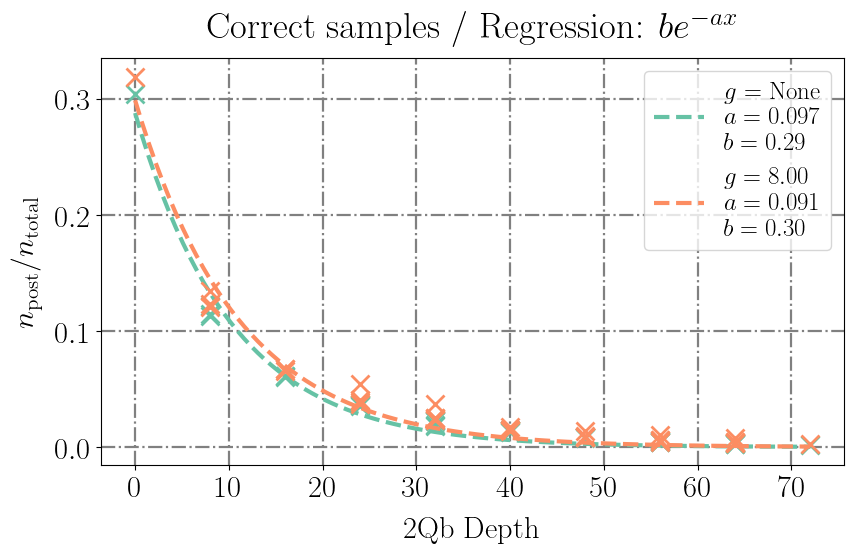

In [19]:
from utils.circs import depth2qb
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

def plot_n_discarded_samples_comparison(samples_dicts_arr, postselected_samples_dicts_arr, g_arr, x_arr=None, resolution=100, x_label=None, regression=False, filepath=""):
    plt.rc("text", usetex=True)
    plt.rc("font", size=22, family="serif", weight="bold")

    if len(samples_dicts_arr) != len(postselected_samples_dicts_arr):
        raise ValueError("Samples and Postselected samples dict are not the same lenght")
    
    if x_arr is None:
        x_arr = np.arange(1, len(samples_dicts_arr)+1)
    else:
        if len(x_arr) != len(samples_dicts_arr[0]):
            raise ValueError("x_arr must be the same length as samples_dicts")
    
    ntotal_samples_arr = np.zeros((len(samples_dicts_arr), len(samples_dicts_arr[0])))
    npostselected_samples_arr = np.zeros((len(samples_dicts_arr), len(samples_dicts_arr[0])))

    for i, (samples_dicts, postselected_samples_dicts) in enumerate(zip(samples_dicts_arr, postselected_samples_dicts_arr)):
        for j, (samples_dict, postselected_samples_dict) in enumerate(zip(samples_dicts, postselected_samples_dicts)):
            nqubits_samples = len(list(samples_dict.keys())[0])
            nqubits_postselected_samples = len(list(postselected_samples_dict.keys())[0])
            if nqubits_samples != nqubits_postselected_samples:
                raise ValueError("Sample dicts in the same posititions must have the same number of qubits")
            ntotal_samples_arr[i, j] = np.sum(list(samples_dict.values()))
            npostselected_samples_arr[i, j] = np.sum(list(postselected_samples_dict.values()))
    
    ratio_arr = npostselected_samples_arr/ntotal_samples_arr
    fig, ax = plt.subplots(figsize=[9, 6])
    reg_func = lambda x, a, b: b*np.exp(-a*x)
    cmap = plt.get_cmap("Set2")
    x_plot = np.linspace(x_arr[0], x_arr[-1], resolution)
    for i, (samples_dicts, postselected_samples_dicts) in enumerate(zip(samples_dicts_arr, postselected_samples_dicts_arr)):
        color = cmap((i % 8)/8 + 0.01)
        if regression:
            popt, pcov = sp.optimize.curve_fit(reg_func, x_arr, ratio_arr[i], p0=[1, 1])
            try:
                g_str = f"$g = {float(g_arr[i]):.02f}$"
            except TypeError:
                g_str = f"$g$ = {str(g_arr[i])}"
            plt.plot(x_plot, reg_func(x_plot, *popt), "--", linewidth=3, color=color, label=f"{g_str}\n$a={popt[0]:.03f}$\n"+f"$b = {popt[1]:0.2f}$")
        plt.plot(x_arr, ratio_arr[i], "x", markersize=13, markeredgewidth=2, color=color)
        plt.grid(color="gray", linestyle="dashdot", linewidth=1.6)
        plt.ylabel(r"$n_{\mathrm{post}}/n_{\mathrm{total}}$", labelpad=10)
        if regression:
            plt.legend(prop={"size":18})
        if x_label is not None:
            plt.xlabel(x_label, labelpad=10)
        else:
            plt.xlabel("Sample sets", labelpad=10)
    plt.title(r"Correct samples / Regression: $b e^{-ax}$", pad=15)
    plt.tight_layout()
    if filepath:
        plt.savefig(filepath, dpi=300, facecolor="none")
    plt.show()
    plt.rcdefaults()

plot_n_discarded_samples_comparison(samples_dicts, postselected_samples_dicts, g_arr=g_arr, x_arr=np.array([depth2qb(circ) for circ in circuits[0]]), x_label="2Qb Depth", regression=True, filepath=f"gauge_dd_samples_comparison_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g_arr[0]}_{g_arr[1]}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_dc_{sampler_options["dynamical_decoupling"]["sequence_type"]}_twirling_{sampler_options["twirling"]["enable_gates"]}_xbasis_{x_basis}.png")

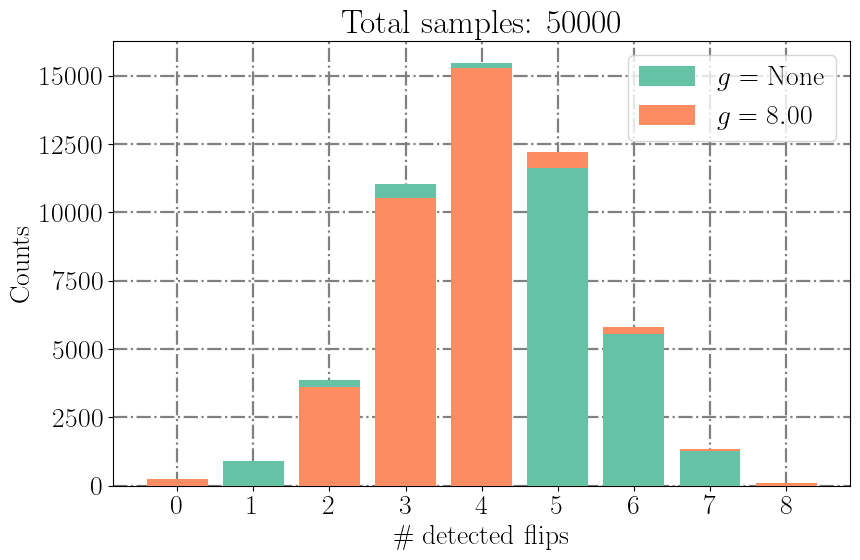

In [39]:
from utils.postselection import diagonal_operators_check, get_layout_state, undo_layout_state
from z2chain.operators import postselection_operators
import matplotlib.pyplot as plt
from collections import Counter
from pymatching import Matching
import numpy as np

depth_index = 3

def plot_nflips_comparison(samples_dicts, postselection_operators, g_arr, circs_layout=None, filepath=""):
    plt.rc("text", usetex=True)
    plt.rc("font", size=20, family="serif", weight="bold")

    if len(samples_dicts) != 2:
        raise ValueError("Only two sample dicts can be compared")

    all_diagonal, basis = diagonal_operators_check(postselection_operators)
    if not all_diagonal:
        raise ValueError("Only supports diagonal postselection operators in some basis")

    postselection_mask = np.array([[int(str(opel) == basis) for opel in operator] for operator in postselection_operators])
    decoder = Matching(postselection_mask)
    flip_counts = []
    total_nflips = np.zeros(len(samples_dicts), dtype=int)
    max_nflips = 0
    for i, samples_dict in enumerate(samples_dicts):
        states = np.array([[int(c) for c in string] for string in samples_dict.keys()])
        state_counts = np.array(list(samples_dict.values()))
        if circs_layout is not None:
            states = get_layout_state(states, circs_layout[i])
        states_syndromes = (states @ postselection_mask.T) % 2
        predicted_flips = decoder.decode_batch(states_syndromes)
        nflips = predicted_flips.sum(axis=1)
        unique_nflips = np.unique(nflips)
        this_flip_counts = {}
        this_total_nflips = 0
        for nf in unique_nflips:
            this_counts = np.sum(state_counts[np.equal(nflips, nf)])
            this_flip_counts[nf] = this_counts
            this_total_nflips += this_counts
        total_nflips[i] = this_total_nflips
        this_max_nflips = max(this_flip_counts.keys())
        if this_max_nflips > max_nflips: max_nflips = this_max_nflips
        flip_counts.append(this_flip_counts)

    if len(np.unique(total_nflips)) > 1:
        print("WARNING: Unfair comparison, different number of total samples")
        
    cmap = plt.get_cmap("Set2")
    x_plot = np.arange(max_nflips+1)
    fig, ax = plt.subplots(figsize=[9, 6])
    bars = []
    ys = []
    for i, fc in enumerate(flip_counts):
        color = cmap((i % 8)/8 + 0.01)
        y_plot = [fc[nf] for nf in x_plot]
        try:
            g_str = f"$g = {float(g_arr[i]):.02f}$"
        except TypeError:
            g_str = f"$g$ = {str(g_arr[i])}"
        this_bars = plt.bar(x_plot, y_plot, color=color, zorder=3, label=g_str)
        ys.append(y_plot)
        bars.append(this_bars)

    for i, (b0, b1) in enumerate(zip(bars[0], bars[1])):
        if ys[0][i] > ys[1][i]:
            b0.zorder = 3
            b1.zorder = 5
        else:
            b0.zorder = 5
            b1.zorder = 3

    plt.xticks(x_plot)
    plt.xlabel(r"\# detected flips")
    plt.ylabel("Counts")
    plt.title(f"Total samples: {np.max(total_nflips)}")
    plt.grid(color="gray", linestyle="dashdot", linewidth=1.6, zorder=0)
    plt.legend()
    plt.tight_layout()
    if filepath:
        plt.savefig(filepath, dpi=300, facecolor="none")
    plt.show()
    plt.rcdefaults()

pops = postselection_operators(L, x_basis)
this_depth_samples_dicts = [samples_dicts[0][depth_index], samples_dicts[1][depth_index]]
circs_layout = [circ.layout.final_index_layout() for circ in [circuits[0][1], circuits[1][1]]]
plot_nflips_comparison(this_depth_samples_dicts, pops, g_arr, circs_layout, f"gauge_dd_nflips_comparison_maxt_{final_time}_steps_{steps}_L_{L}_J_{J:.04f}_h_{h:.04f}_lamb_{lamb:.04f}_g_{g_arr[0]}_{g_arr[1]}_pp_{particle_pair_left_position}_pl_{particle_pair_length}_dc_{sampler_options["dynamical_decoupling"]["sequence_type"]}_twirling_{sampler_options["twirling"]["enable_gates"]}_xbasis_{x_basis}.png")